In [1]:
import pandas as pd
import numpy as np
import random
import itertools
import requests
import contextlib
import warnings
from tqdm import tqdm  
import seaborn as sns
from numpy.random import rand
from random import randint
import joblib 
from joblib import Parallel, delayed
warnings.filterwarnings("ignore")

# 1. Import function & File

In [2]:
# Function for calculating entropy
def entro_cal(mat_prop,ts_cal):
    
    #mat_prop: averaged protein activities across time
    #ts_cal: simulated time step
    
    #prep data
    en_ = mat_prop.copy()
    en_.columns = [cl_ for cl_ in range(en_.shape[1])]   
    list_ = ["".join(map(str, list(en_[col])))for col in range(ts_cal)]
    en_2 = pd.DataFrame({"S":list_}).groupby("S").size().reset_index().rename({0:"CNT"},axis=1)["CNT"]
    en_3 = np.array(en_2)

    # entropy calculation
    prob_ = en_3/ts_cal
    log_p = np.log2(prob_)
    entropy_ = -sum([prob_[_] * log_p[_] for _ in range(len(log_p))])
    return entropy_


# Function for generating cell line specific profile from gene expression and mutation data
def cell_line_profile (**args):
    
    
    globals().update(args)

    """
    1.1 Prep. File
    """
    # 1.1 gene expression: initial state
    ex_tmp = mdf_gx_final.query("cl == @cl_name").iloc[:,[1,2]]
    ex_tmp.columns = ["target","state"]
    ex_tmp["state"] = [int(np.random.choice([0,1], 1, p=[1-ex_tmp.iloc[i,1],ex_tmp.iloc[i,1]])) for i in range(ex_tmp.shape[0])]


    # 1.2 mutation: fix at Boolean function
    cl_tmp = cl_mut_.query("cl == @cl_name")[["target","value"]].drop_duplicates() 
    cl_tmp.columns = ["target","state"]

    dict_omic = {"ex_tmp":ex_tmp,
                 "cl_tmp":cl_tmp}

    rule_ran = [dict_omic[x] for x in hyp_rule]
    init_ran = [dict_omic[x] for x in hyp_init]   


    """
    1.2 mutation: fix 0 and 1 at Boolean function
    """

    select_ = pd.concat(rule_ran).groupby(['target']).agg({'state': 'max'}).reset_index().query("target == @gene_list")
    exs_list = select_["target"].tolist()
    bool_cl = boolean_function.query("target != @exs_list")
    bool_cl_fixed = pd.concat([bool_cl, select_]).groupby(['target']).agg({'state': 'max'}).reset_index()


    #reorder row of protein
    bool_cl_fixed.target = bool_cl_fixed.target.astype("category")
    bool_cl_fixed.target.cat.set_categories(gene_list, inplace=True)
    bool_cl_fixed = bool_cl_fixed.sort_values(["target"])



    """
    1.3  gene expression: generate initial state 
    """

    init_gx = pd.concat(init_ran).groupby(['target']).agg({'state': 'max'}).reset_index().query("target == @gene_list").query("target != @exs_list")
    all_list = init_gx['target'].tolist()
    remain = boolean_function.query("target != @all_list")
    #the initial state any protein without information in gene expression will be randomly selected 1 or 0.
    remain["state"] = [int(np.random.choice([0,1], 1, p=[0.5,0.5])) for i in range(remain.shape[0])]
    final_init_state = pd.concat([init_gx,remain,select_]).groupby(['target']).agg({'state': 'max'}).reset_index()

    #reorder row of protein
    final_init_state.target = final_init_state.target.astype("category")
    final_init_state.target.cat.set_categories(gene_list, inplace=True)
    initial_state = final_init_state.sort_values(["target"])

    res_final = [initial_state,bool_cl_fixed]



    return res_final


# Function for generating drug profile based on dose ranges
# list of all of available drug kept in this function
def assign_rule_drug(**args):

    globals().update(args)
    
    # gene name
    gene_name_v2 =  fl.parse(0).iloc[:,:2]
    gene_name_v2.columns = ["protein","model_name"] 

    #cell line - Boolean Rule fixed by genetic mutation
    boolean_rule = cell_line_profile(**args)[1].reset_index().iloc[:,1:]

    #drug row
    tg_drug_row = drug_target.query("drug  == @drug_1")
    tg_drug_row_ = pd.merge(gene_name_v2,tg_drug_row,on="protein").query("model_name == @gene_list")

    #drug col
    tg_drug_col = drug_target.query("drug  == @drug_2")
    tg_drug_col_ = pd.merge(gene_name_v2,tg_drug_col,on="protein").query("model_name == @gene_list")


    def dose_range(dose_):

        #dose of each drug
        dose_1st_drug = dose_[0]
        dose_2nd_drug = dose_[1]

        #assign drug
        def assign_drug(df,dose):
            
            #check which drug target is ON and OFF based on the dose probability 
            nrow_dr = df.shape[0]
            df["response_adj"] = [int(np.random.choice([0,1], 1, p=[1-dose,dose])) for i in range(nrow_dr)]
            #target will be perturbed by drug if it is equal to 1 which is based on probability.
            pow_dr = df.query("response_adj == 1")

            
            if (True in pow_dr.drug.str.contains('391210-10-9').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'MEK_i', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('915019-65-7').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'PI3K_c', 'response_adj'] = 0
                pow_dr.loc[pow_dr['model_name'] == 'MTORC1_c', 'response_adj'] = 0
                pow_dr.loc[pow_dr['model_name'] == 'MTORC2_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('ALPELISIB').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'PI3K_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('ANTIBIOTIC AY 22989').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'MTORC1_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('AZD2014').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'MTORC1_c', 'response_adj'] = 0
                pow_dr.loc[pow_dr['model_name'] == 'MTORC2_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('AZD5363').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'AKT_i', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('BUPARLISIB').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'PI3K_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('CELECOXIB').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'PDPK1', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('DASATINIB').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'SRC', 'response_adj'] = 0
                pow_dr.loc[pow_dr['model_name'] == 'LCK', 'response_adj'] = 0
                pow_dr.loc[pow_dr['model_name'] == 'ABL1', 'response_adj'] = 0
                pow_dr.loc[pow_dr['model_name'] == 'ABL2', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('DEFOROLIMUS').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'MTORC1_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('EMCYT').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'ESR1', 'response_adj'] = 1

            if (True in pow_dr.drug.str.contains('ENZASTAURIN').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'AKT_i', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('ERLOTINIB').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'EGFR', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('ERLOTINIB HYDROCHLORIDE').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'EGFR', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('FULVESTRANT').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'ESR1', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('GEFITINIB').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'EGFR', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('GELDANAMYCIN').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'HSP90AA1', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('IMATINIB').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'ABL1', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('LAPATINIB').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'EGFR', 'response_adj'] = 0
                pow_dr.loc[pow_dr['model_name'] == 'HER2', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('MEGESTROL ACETATE').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'PGR', 'response_adj'] = 1

            if (True in pow_dr.drug.str.contains('MITOTANE').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'ESR1', 'response_adj'] = 1

            if (True in pow_dr.drug.str.contains('MK-2206').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'AKT_i', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('MK-8669').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'MTORC1_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('NILOTINIB').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'ABL1', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('NSC733504').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'MTORC1_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('PACLITAXEL').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'BCL2', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('PF-04691502').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'PI3K_c', 'response_adj'] = 0
                pow_dr.loc[pow_dr['model_name'] == 'MTORC1_c', 'response_adj'] = 0
                pow_dr.loc[pow_dr['model_name'] == 'MTORC2_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('RALOXIFENE').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'ESR1', 'response_adj'] = 1

            if (True in pow_dr.drug.str.contains('RUXOLITINIB').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'JAK2', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('SAPITINIB').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'HER2', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('SELUMETINIB').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'MEK_i', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('SORAFENIB').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'EGFR', 'response_adj'] = 0
                pow_dr.loc[pow_dr['model_name'] == 'RAF1', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('STATTIC').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'STAT3', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('TAMOXIFEN CITRATE').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'ESR1', 'response_adj'] = 0
                pow_dr.loc[pow_dr['model_name'] == 'MAPK8', 'response_adj'] = 1

            if (True in pow_dr.drug.str.contains('TEMSIROLIMUS').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'MTORC1_c', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('TRAMETINIB').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'MEK_i', 'response_adj'] = 0

            if (True in pow_dr.drug.str.contains('TRISENOX').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'JUN', 'response_adj'] = 1
                pow_dr.loc[pow_dr['model_name'] == 'CYCLIN_D_c', 'response_adj'] = 0
                pow_dr.loc[pow_dr['model_name'] == 'ERK_i', 'response_adj'] = 1
                pow_dr.loc[pow_dr['model_name'] == 'AKT_i', 'response_adj'] = 1

            if (True in pow_dr.drug.str.contains('VANDETANIB').tolist()) == True:
                pow_dr.loc[pow_dr['model_name'] == 'EGFR', 'response_adj'] = 0

            return pow_dr
        

        #combine drug effect from both drug
        cdrug2 = pd.concat([assign_drug(tg_drug_row_, dose_1st_drug),
                   assign_drug(tg_drug_col_, dose_2nd_drug)])[["model_name","response_adj"]]

        #### drug conflict ----> inhibitor always win 
        conflict_ = cdrug2.groupby("model_name").mean().query("response_adj == 0.5").reset_index()["model_name"].tolist()
        cdrug_filter = cdrug2.query("model_name != @conflict_") 
        select_df = cdrug2.query("model_name == @conflict_ and response_adj != 1")
        cdrug = pd.concat([select_df,cdrug_filter])

        ####

        cdrug.columns = ["target","state"]

        if cdrug.shape[0] == 0:
            final_adjs = boolean_rule.copy()
            df = final_adjs.set_index('target')
            final_adj = df.loc[gene_list].reset_index()
            final_adj["dose_row"] = dose_1st_drug
            final_adj["dose_col"] = dose_2nd_drug

            return final_adj.drop_duplicates()

        else:            
            bc_ = boolean_rule.query("target != @cdrug.target.tolist()")
            final_adjs = pd.concat([bc_,cdrug.drop_duplicates()])
            df = final_adjs.set_index('target')
            final_adj = df.loc[gene_list].reset_index()
            final_adj["dose_row"] = dose_1st_drug
            final_adj["dose_col"] = dose_2nd_drug

            return final_adj

    # Generating perturbed Boolean rule across dose ranges
    res = [dose_range(_)["state"].tolist() for _ in big_mat_]

    return res



# Function for simulating drug perturbation
def asyn_inhibitor_opt(**args):
    

    globals().update(args)       
    
    # simulating time: total time step = cancer steady state + 5000
    time_step_ = elbow + 5000
    
    # time step to perturbed drug
    time_treat_drug_ = elbow
  
    
    res = [init_idx_]
    init_idx_2 = init_idx_.copy()
    
    
    for j in range(time_step_):

        ran_num = random.randint(0, len(bool_)-1)
        
        if j < time_treat_drug_:
            
            if j == 0:
            
                update_ = np.array([eval(bool_[x],init_)*1 for x in range(len(bool_))])
                bget = np.append(np.array([i for i, x in enumerate(bool_) if x == "1" or x == "0"]),ran_num).astype(int)
                init_idx_2[bget]= update_[bget]
                res.append(init_idx_2)
            
            else:
                
                val = np.array(res[j])
                update_ = dict(zip(keys_idx_, val))
                update_step = [eval(bool_[x],update_)*1 for x in range(len(bool_))]
                val[ran_num]= update_step[ran_num] 
                res.append(val)
            
        else:
            
            val_2 = np.array(res[j])
            idx_drug_fixed = np.array([i for i, x in enumerate(bool_treat_drug_) if x == "1" or x == "0" or x == 1 or x == 0]).astype(int)
            val_2[idx_drug_fixed] = bool_treat_drug_[idx_drug_fixed] 
            update_drug = dict(zip(keys_idx_,val_2))
            update_drug_step = np.array([eval(bool_treat_drug_[x],update_drug)*1 for x in range(len(bool_))])  
            val_2[ran_num]= update_drug_step[ran_num]
            res.append(val_2)
            
            
    return res

# Function for summarizing result
def get_para(reps,**args):
    
    bl_cl = cell_line_profile(**args)[1].reset_index().iloc[:,1:]
    
    init_cl = cell_line_profile(**args)[0].reset_index().iloc[:,1:]
    
    bool_ = [str(x) for x in sum(bl_cl[["state"]].to_numpy().tolist(),[])]
    
    init_ = dict(init_cl[["target","state"]].values)
    
    keys_idx = list(init_.keys())
    
    init_idx = np.array([init_.get(x) for x in keys_idx])

    drug_rule_ = assign_rule_drug(**args)
    
    
    dict_list = []
    for j in range(len(drug_rule_)):
    
        all_parameter = {"bool_":bool_,
                         "init_":init_,
                         "keys_idx_": keys_idx,
                         "init_idx_":init_idx,
                         "bool_treat_drug_": np.array(drug_rule_[j]), 
                         "elbow":SS[cl_name]}    
        
        dict_list.append(all_parameter)
        

    return dict_list



In [3]:
# Prep. drug target and readout
fl = pd.ExcelFile("data/GRN.xls")
gene_list = fl.parse(1)['target'].tolist()

gene_name =  fl.parse(0).iloc[:,:2]
gene_name.columns = ["HGNC","model_name"] 

drug_target = pd.read_csv("data/drug_target.csv")
read_out = ["CYCLIN_D_c","MTORC1_c","ESR1","BCL2","PAK1","STAT3","PGR","WNT1","P21","CASP3","GATA3","FADD","BID"]


In [4]:
#Prep. omics profile
##gene expression
cl_name = ["MCF7","T47D","BT549","MDAMB436","MDAMB231","MDAMB468"]
mdf_gx = pd.read_csv("data/omics/gx_fpkm_sanger_broad.csv.gz").iloc[:,1:].query("cl == @cl_name").rename({"variable":"HGNC"},axis=1)
mdf_gx_ = pd.merge(mdf_gx,gene_name,on="HGNC")[["cl","model_name","value"]]
mdf_gx_final = mdf_gx_.groupby(['cl','model_name']).agg({'value': 'mean'}).reset_index()
mdf_gx_final.columns = ["cl","target","value"]

##genetic mutation
cl_mut = pd.read_csv("data/omics/mutations_sanger_broad.csv.gz").iloc[:,1:].rename({"gene":"HGNC"},axis=1)
cl_mut_ = pd.merge(cl_mut,gene_name,on="HGNC")[["displayName","model_name","status"]]
cl_mut_.columns = ["cl","target","value"]


In [5]:
# omics profile used for cell line 
rule_idx = pd.DataFrame([[["cl_tmp"],["ex_tmp"],"MCF7"],
[["cl_tmp"],["ex_tmp"],"T47D"],
[["cl_tmp"],["ex_tmp"],"MDAMB231"],
[["cl_tmp"],["ex_tmp"],"MDAMB468"],
[["cl_tmp"],["ex_tmp"],"BT549"]],columns=["rule","init","cl"])

# 2. Select cell line and drug pair

In [9]:
#number of repeats -> higher number of repeat might take some time to run 
simr = 5
# cell line 
cell_line = "MCF7"
sheet_index = {"MCF7":1,"T47D":2,"MDAMB468":3,"MDAMB231":4,"BT549":5}
boolean_function = fl.parse(sheet_index[cell_line]).iloc[:,:2] 

# drug pair
drug_A = "AZD5363"
drug_B = "FULVESTRANT"

# 3. Select Dose range

In [10]:
# matrix for simulation
# dose range must be between 0 and 1
big_mat_ = []
for f_dose in [0,0.25,0.75,1]:
    for s_dose in [0,0.25,0.75,1]:
        col = [f_dose,s_dose]
        big_mat_.append(col)      


# 4. Run simulation

## Step 1:  Prepare function arguments as a dict

In [11]:
rand_bool = rule_idx.query("cl == @cell_line").iloc[0,0]
rand_init = rule_idx.query("cl == @cell_line").iloc[0,1]


args = {"cl_name":cell_line, # selcted cell line in (2)
        "boolean_function":boolean_function, #selected boolean function based on cell line
        "hyp_rule":rand_bool, #genetic mutation for fixing Boolean rule
        "hyp_init":rand_init, # gene expression for initial state
        "drug_1":drug_A, # 1st drug name
        "drug_2":drug_B} # 2nd drug name

#steady state of unperturbed cell lines
SS = {"MCF7":3500,
      "T47D":2750,
      "MDAMB231":2250,
      "MDAMB468":3500,
      "BT549":3500}


## Step 2:  Run drug-perturbed simulation

In [12]:

print("---Preparing file ---")
# prepare cell-line-specific Boolean rule and initial state through n simulations
all_set = Parallel(n_jobs=-1,backend="threading")(delayed(get_para)(i,**args) for i in range(simr))

print("---Simulating ---")
# drug perturb simulation
df_list = []
for count, j in enumerate(all_set):
    print("running ----->  "+str(count)+ " repeat")
    set_ = Parallel(n_jobs=-1,backend="threading")(delayed(asyn_inhibitor_opt)(**k) for k in tqdm(j))
    df_list.append(set_)

---Preparing file ---
---Simulating ---
running ----->  0 repeat


100%|███████████████████████████████████████████| 16/16 [00:47<00:00,  2.99s/it]


running ----->  1 repeat


100%|███████████████████████████████████████████| 16/16 [00:35<00:00,  2.20s/it]


running ----->  2 repeat


100%|███████████████████████████████████████████| 16/16 [00:36<00:00,  2.29s/it]


running ----->  3 repeat


100%|███████████████████████████████████████████| 16/16 [02:20<00:00,  8.75s/it]


running ----->  4 repeat


100%|███████████████████████████████████████████| 16/16 [01:53<00:00,  7.07s/it]


## Step 3:  Averaging protein activities from an asynchronous update in each dose

In [13]:
#summarize result
res_list = []
for reps,j in enumerate(df_list):
    for k in range(len(big_mat_)):
        df_cat = pd.DataFrame(j[k])
        df_cat_2 = df_cat.T
        df_cat_2.index = gene_list
        df_cat_2["dose"] = '_'.join(map(str, big_mat_[k]))
        df_cat_2["repeats"] = reps
        res_list.append(df_cat_2)

In [14]:
df_ = pd.concat(res_list)
df_["protein"] = df_.index
df_2 = df_.groupby(["dose","protein"]).mean().reset_index()

## Step 4: Collecting protein activities at steady state

In [23]:
df_3 = df_2.drop(["repeats"],axis=1).melt(id_vars=["dose","protein"])
# it might take long time to run entropy function, we simply collected the steady state at last 500 row
ss = np.max(df_3.variable.unique())-500
df_4 = df_3.query("variable >= @ss")

## Step 5: Averaging the readout protein activity  across dose ranges

In [24]:
df_5 = df_4.query("protein == @read_out").groupby(["dose","protein"]).mean().reset_index()

In [25]:
df_6 = df_5.groupby("protein").mean().reset_index()
df_7 = df_6.set_index('protein')
df_8 = df_7.reindex(read_out)
df_9 = df_8.reset_index()

## Step 6: Visualizing the protein synergy score and contribution of each readout member

Text(0.5, 1.0, 'Predicted HSA synergy score = 3.9')

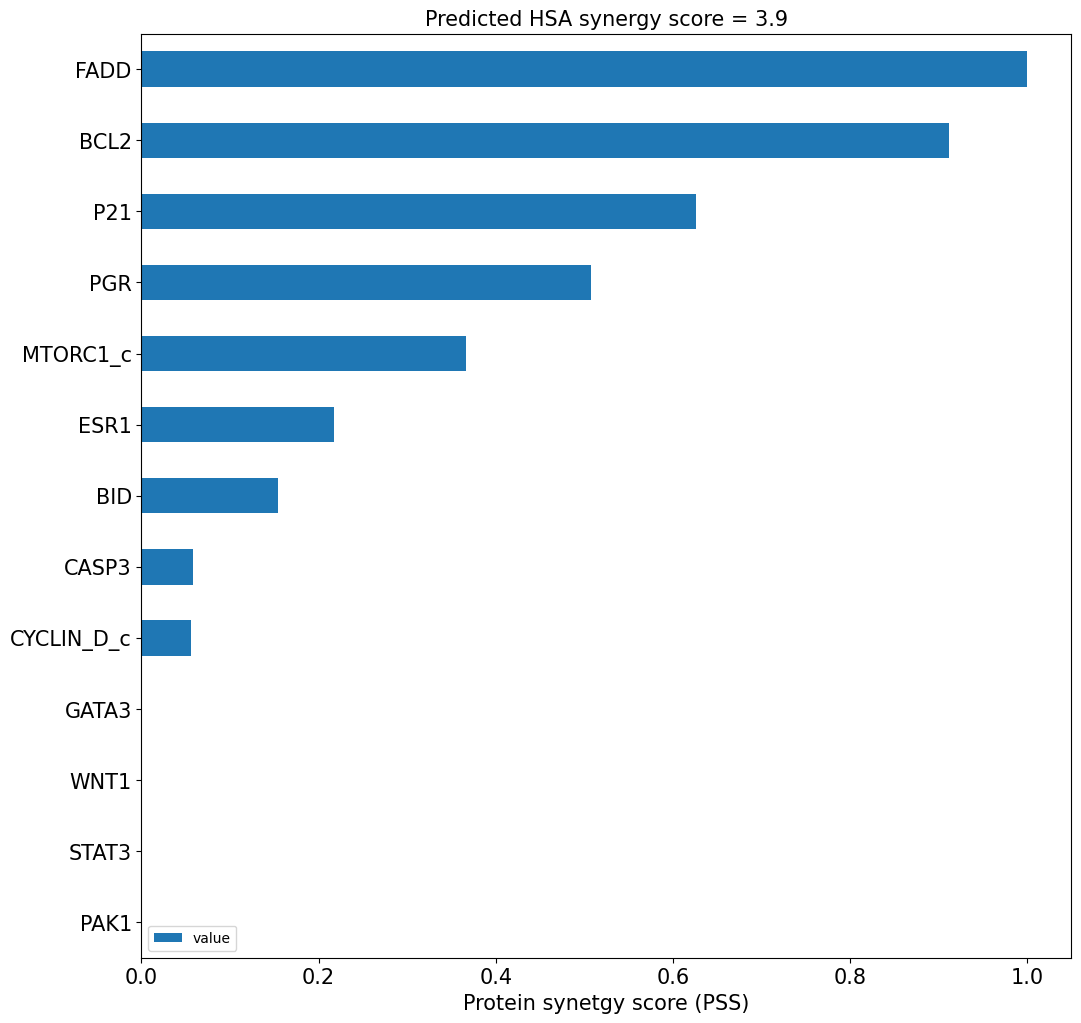

In [26]:
title = "Predicted HSA synergy score = "+str(np.round(df_9.value.sum(),2))
ax = df_9.sort_values(by="value").plot.barh(x="protein",y='value', rot=0,figsize=(12,12),fontsize=15)
ax.set_xlabel("Protein synetgy score (PSS)",fontdict={'fontsize':15})
ax.set_ylabel("")
ax.set_title(title,fontdict={'fontsize':15})